In [1]:
!pip install statsmodels


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [10]:
# Load the dataset
df = pd.read_csv('journey.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)

# Sort by date and set frequency
df = df.sort_index()
df = df.asfreq('D')
df.fillna(method='ffill', inplace=True)


<ipython-input-10-e8d2642f4d3b>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


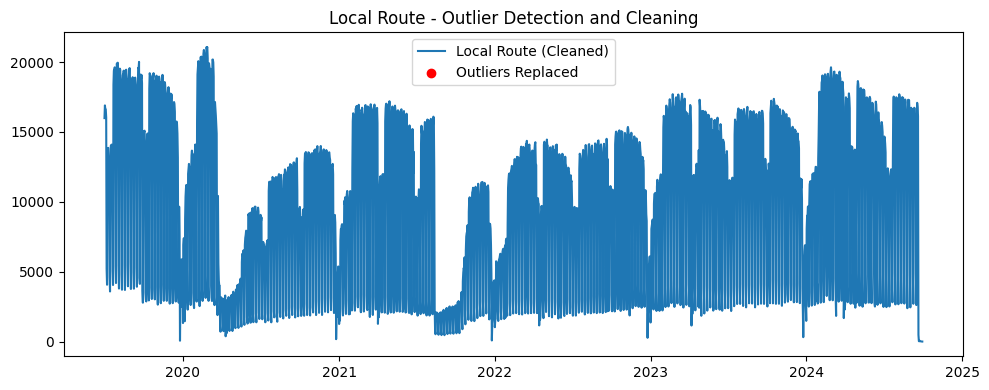

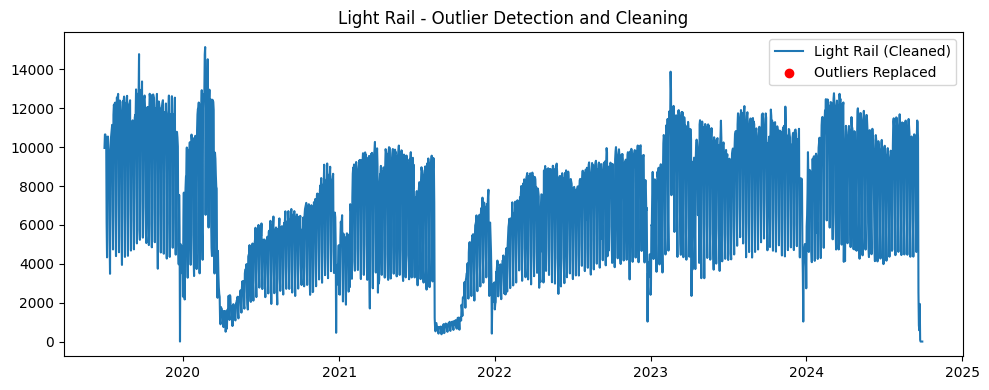

<ipython-input-11-504191c31c47>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[474.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, service] = rolling_mean[outliers]


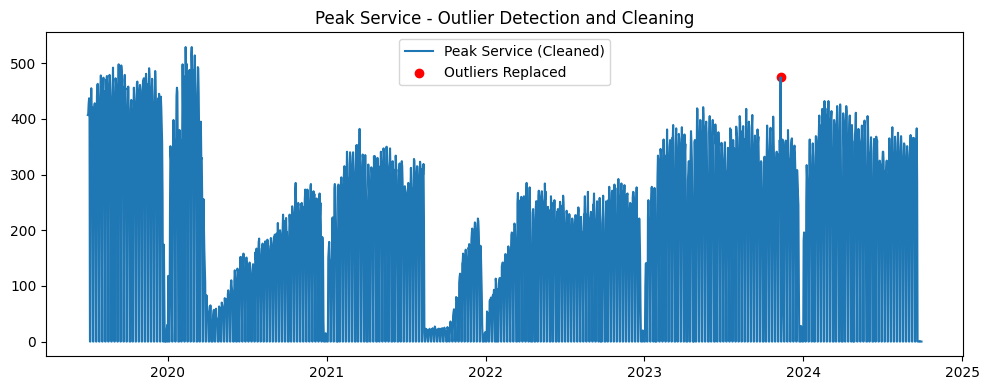

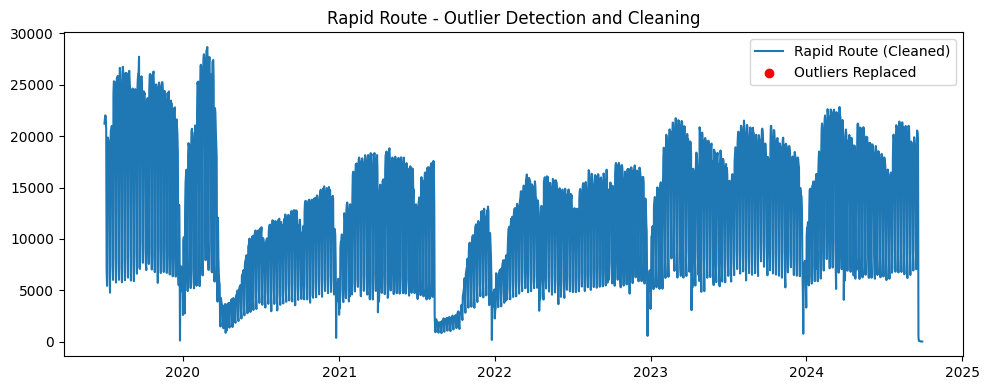

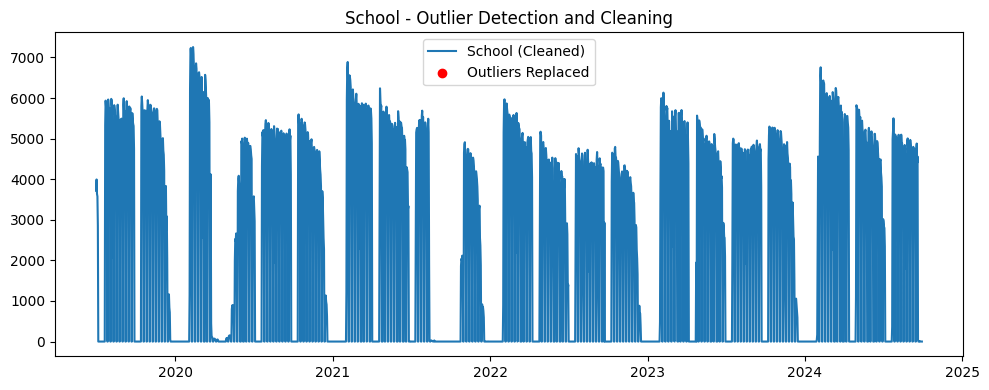

In [11]:
services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

for service in services:
    z = np.abs(stats.zscore(df[service].dropna()))
    outliers = z > 3
    df[f'{service}_outlier'] = outliers

    rolling_mean = df[service].rolling(5, min_periods=1).mean()
    df.loc[outliers, service] = rolling_mean[outliers]

    plt.figure(figsize=(10, 4))
    plt.plot(df[service], label=f'{service} (Cleaned)')
    plt.scatter(df.index[outliers], rolling_mean[outliers], color='red', label='Outliers Replaced')
    plt.title(f"{service} - Outlier Detection and Cleaning")
    plt.legend()
    plt.tight_layout()
    plt.show()


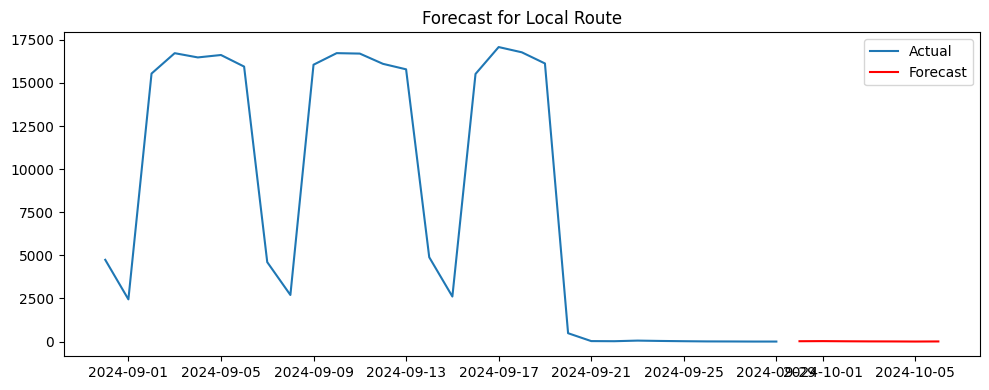

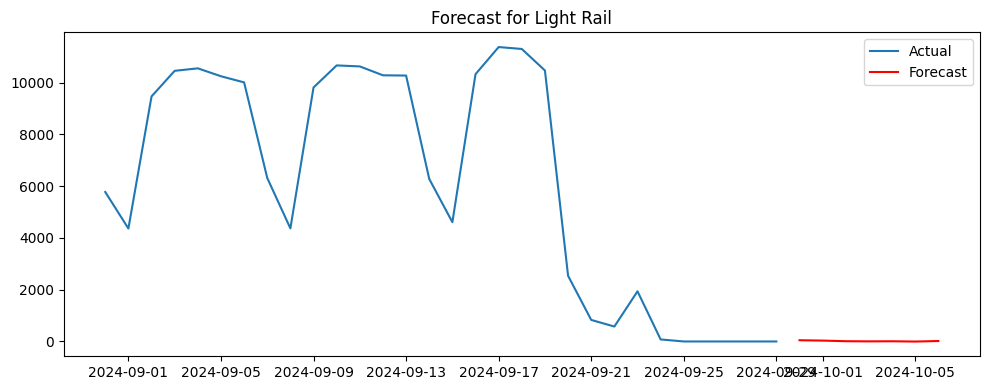

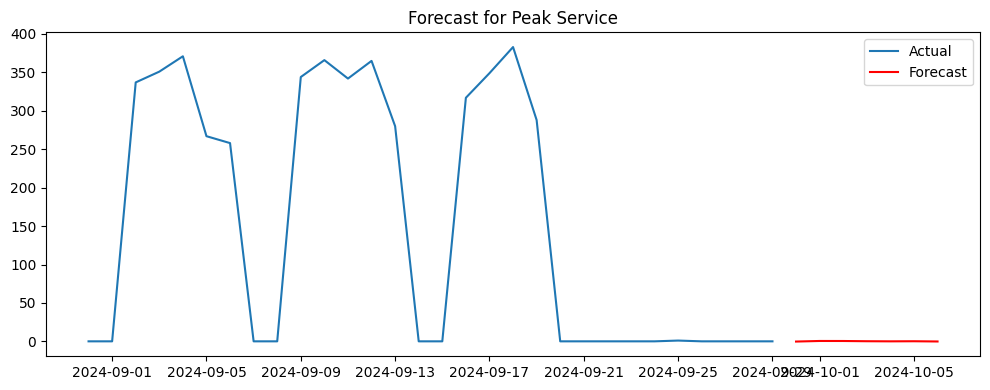

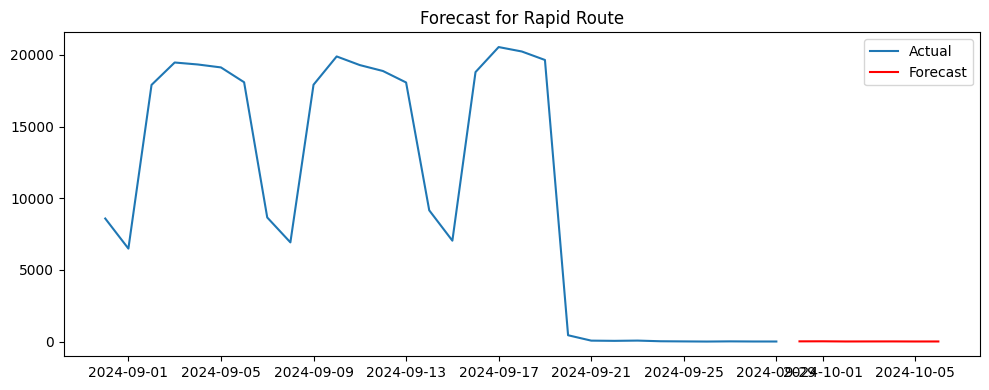

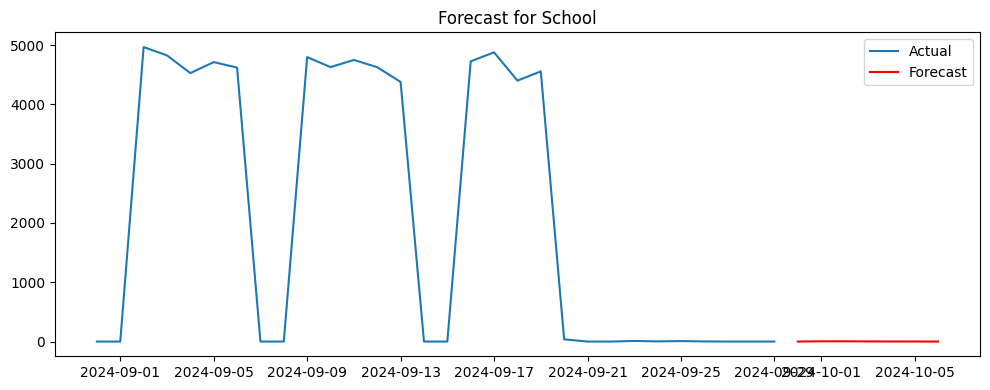

In [12]:
forecast_horizon = 7
forecast_results = {}

for service in services:
    series = df[service].dropna()
    model = ARIMA(series, order=(5, 1, 0))  # You can tune this
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_horizon)

    forecast_results[service] = forecast

    # Plot forecast
    plt.figure(figsize=(10, 4))
    plt.plot(series[-30:], label='Actual')
    plt.plot(pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon),
             forecast, label='Forecast', color='red')
    plt.title(f"Forecast for {service}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
for service in services:
    y_pred = forecast_results[service]
    y_true = df[service][-forecast_horizon:]
    y_true = y_true[:len(y_pred)]  # Align length

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n Evaluation for {service}:")
    print(f"MAE  = {mae:.2f}")
    print(f"MSE  = {mse:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAPE = {mape:.2f}%")
    print(f"R²   = {r2:.2f}")



 Evaluation for Local Route:
MAE  = 8.54
MSE  = 207.98
RMSE = 14.42
MAPE = nan%
R²   = 0.44

 Evaluation for Light Rail:
MAE  = 282.49
MSE  = 510796.44
RMSE = 714.70
MAPE = nan%
R²   = -0.12

 Evaluation for Peak Service:
MAE  = 0.25
MSE  = 0.10
RMSE = 0.31
MAPE = nan%
R²   = 0.20

 Evaluation for Rapid Route:
MAE  = 10.89
MSE  = 421.70
RMSE = 20.54
MAPE = nan%
R²   = 0.09

 Evaluation for School:
MAE  = 2.38
MSE  = 16.79
RMSE = 4.10
MAPE = nan%
R²   = -0.16
